# Including 'Hofstadter SP with Theta Phases' and 'First Band Approximation' Functions

In [1]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Theta Space.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Initial Parameters

In [2]:
Nx=4;Ny=4;N=Nx*Ny
p=1;q=Ny;alpha=p/q
PN=[0,1,2]
cut_off=4
U = 2
T_size=10;

# Single Particle

In [3]:
function Sp_Theta_Op(Nx, Ny, alpha, sp_basis, Tx, Ty)
    
    N = Nx*Ny
    
    H_T = HSP_T(Nx, Ny, alpha, Tx, Ty, 0)
    
    H = SparseOperator(sp_basis)
    
    for m in 1:N
        for n in 1:N
            H = H + H_T[m,n] * transition(sp_basis, m, n)
        end
    end
    
    return H
end

Sp_Theta_Op (generic function with 1 method)

In [4]:
using LinearAlgebra
eigvals(HSP_T(Nx, Ny, p/q, 21, 121, 0))
# Dejenerelik Tx ve Ty değerine bağlı değil, yani cut-off değerinden bağımsızdır.

16-element Vector{Float64}:
 -2.6995245464107374
 -2.6995245464107374
 -2.699524546410737
 -2.699524546410736
 -0.8441369695291789
 -0.8441369695291787
 -0.8441369695291778
 -0.8441369695291774
  0.8441369695291773
  0.8441369695291778
  0.8441369695291785
  0.8441369695291789
  2.699524546410736
  2.699524546410736
  2.6995245464107382
  2.69952454641074

# MB

In [5]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [6]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN);

# Total Hamiltonian

In [7]:
sp_basis = NLevelBasis(N)
function get_total_H(Nx, Ny, alpha, sp_basis, Tx, Ty, cut_off, PN, basis_cut_sp, basis_cut_mb)
    H1 = Sp_Theta_Op(Nx, Ny, alpha, sp_basis, Tx, Ty)
    sub_states = get_sub_states(H1, cut_off)
    basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)
    H1_sub = get_subspace_op(H1, P, Pt)
    states_mb = bosonstates(basis_sub, PN)     
    basis_mb = ManyBodyBasis(basis_sub, states_mb)
    H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub)
    H1cut = SparseOperator(basis_cut_mb)
    H1cut.data = H1_MB.data
    H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off)
    return H1cut + H_Int
end

get_total_H (generic function with 1 method)

# CHERN CALCULATION SECTION

In [8]:
dx=2*pi/T_size
dy=dx
Tx=collect(range(start=0, stop=2*pi-dx, step=dx))
Ty=collect(range(start=0, stop=2*pi-dy, step=dy));

In [9]:
H_Total = get_total_H(Nx, Ny, alpha, sp_basis, 1, 1, cut_off, PN, basis_cut_sp, basis_cut_mb);

In [12]:
function get_Matrix_form(basis_cut_mb, H_total)
    HH_total_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb));
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            HH_total_Matrix[i,j] = ((H_total+dagger(H_total))/2).data[i,j]
        end
    end
    return HH_total_Matrix
end

get_Matrix_form (generic function with 1 method)

In [13]:
H_total_Matrix = get_Matrix_form(basis_cut_mb, H_Total)
E = eigvals(H_total_Matrix)
# Matrix form of eigen-states
UU = eigvecs(H_total_Matrix);

In [14]:
PN

3-element Vector{Int64}:
 0
 1
 2

In [15]:
using DataFrames

function get_filtered_energies(pn, basis, H_total)
    # Operator form of eigenstates:
    E, UUU = eigenstates(dense(dense((H_total+dagger(H_total))/2)))
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), UUU[i]))
        PN_Energies[i,2] = E[i]
    end
    
    # filter
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_filtered_energies (generic function with 1 method)

In [16]:
pn = 2.0
df = get_filtered_energies(pn, basis_cut_mb, H_Total)
filtered_energies = Matrix(df)[:,2]

10-element Vector{Float64}:
 -5.563960315357841
 -5.56396031535784
 -5.431250873308429
 -5.431250873308426
 -5.322481750448847
 -5.322481750448845
 -5.322481750448845
 -5.322481750448843
 -5.222234062680269
 -5.222234062680267

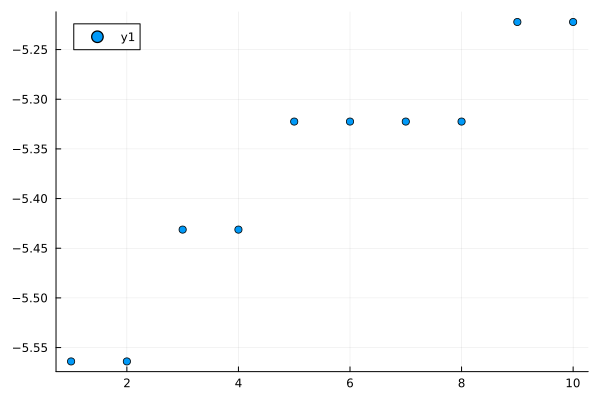

In [17]:
using Plots
plot(1:length(filtered_energies),filtered_energies,seriestype=:scatter)

In [18]:
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[:,1:number_of_states];
end

Restricted_Hubbard_States (generic function with 1 method)

In [22]:
pn = 2
function get_eigenstates(basis_cut_mb, H_Total, pn)
    
    H_total_Matrix = get_Matrix_form(basis_cut_mb, H_Total)
    E = eigvals(H_total_Matrix)
    UU = eigvecs(H_total_Matrix)
    df = get_filtered_energies(pn, basis_cut_mb, H_Total)
    filtered_energies = Matrix(df)[:,2]
    r_hubbard_states = Restricted_Hubbard_States(UU);
    
    return filtered_energies, r_hubbard_states
end

get_eigenstates (generic function with 1 method)

In [45]:
function Chern_Nums(n1, n2)
    
    Sum=0
    
    for tx in range(start=1, stop=length(Tx))
        for ty in range(start=1, stop=length(Ty))
            
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w1, v1 = get_eigenstates(basis_cut_mb, H_Total, pn);
            
            # sorting eigenvalues
            i = sortperm(w1, by=real);w1 = w1[i]
            # sorting eigenstates
            v1 = v1[:,i]
            # multiplet eigenstates
            v1 = v1[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty], cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w2, v2 = get_eigenstates(basis_cut_mb, H_Total, pn);
            
            i = sortperm(w2, by=real);w2 = w2[i]
            v2 = v2[:,i]
            v2 = v2[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx], Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w3, v3 = get_eigenstates(basis_cut_mb, H_Total, pn);
            
            i = sortperm(w3, by=real);w3 = w3[i]
            v3 = v3[:,i]
            v3 = v3[:,n1:n2]
            
            #------------------------------------
            H_Total = get_total_H(Nx, Ny, alpha, sp_basis, Tx[tx]+dx, Ty[ty]+dy, cut_off, PN, basis_cut_sp, basis_cut_mb)
            
            w4, v4 = get_eigenstates(basis_cut_mb, H_Total, pn);
            
            i = sortperm(w4, by=real);w4 = w4[i]
            v4 = v4[:,i]
            v4 = v4[:,n1:n2]
            
            #----------LINK VARIABLES------------
            U1=det(adjoint(v1)*v2)
            U1=U1/abs(U1)
            U2=det(adjoint(v2)*v4)
            U2=U2/abs(U2)
            U3=det(adjoint(v3)*v4)
            U3=U3/abs(U3)
            U4=det(adjoint(v1)*v3)
            U4=U4/abs(U4)
            
            #----------BERRY CURVATURE-----------
            F=log(U1*U2*1/U3*1/U4)
            Sum=Sum+F
            
        end
    end
    
    return 1/(2*pi*1im)*Sum
end

Chern_Nums (generic function with 2 methods)

In [46]:
Chern_Nums(1, 2)

6.795488500978664 - 2.357936446589004e-16im